## LAB 2.1 A: Custom CNN for Binary Classification of Dogs and Cats with Tensorflow

### Proceedure:

- In `dogs_cats_pandas` dataset, only use dogs and cats images.
- The problem turns into a binary classification problem.
- Only use 300 training samples and 100 validation samples (I'm assuming dogs and cats each have 300 train and 100 val).
- Run prediction, compare a "traditional CNN" to HOG feature extraction piped into classification.

In [8]:
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import cv2
import numpy as np

cat_dir = "data/dogs_cats_pandas/animals/cats"
dog_dir = "data/dogs_cats_pandas/animals/dogs"

cat_images = sorted(os.listdir(cat_dir))
dog_images = sorted(os.listdir(dog_dir))

cats_selected = cat_images[:300] + cat_images[-100:]
dogs_selected = dog_images[:300] + dog_images[-100:]

print("Number of cat images used:", len(cats_selected))
print("Number of dog images used:", len(dogs_selected))

min_dim = float('inf')
max_dim = 0
total_w, total_h, count = 0, 0, 0
for img_name in cats_selected + dogs_selected:
    if img_name in cat_images:
        path = os.path.join(cat_dir, img_name)
    else:
        path = os.path.join(dog_dir, img_name)
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        min_dim = min(min_dim, h, w, min_dim)
        max_dim = max(max_dim, h, w, max_dim)
        total_w += w
        total_h += h
        count += 1
avg_w = total_w / count
avg_h = total_h / count

print("Smallest dimension among selected dataset:", min_dim)
print("Largest dimension among selected dataset:", max_dim)
print("Average width:", avg_w)
print("Average height:", avg_h)

def load_images(file_list, directory, target_size=150):
    data = []
    for fname in file_list:
        img = cv2.imread(os.path.join(directory, fname))
        img = cv2.resize(img, (target_size, target_size))
        img = img.astype("float32") / 255.0
        data.append(img)
    return np.array(data)

cats_train = load_images(cat_images[:300], cat_dir)
dogs_train = load_images(dog_images[:300], dog_dir)
cats_val = load_images(cat_images[-100:], cat_dir)
dogs_val = load_images(dog_images[-100:], dog_dir)

print("Sample shape:", cats_train[0].shape)

train_set = np.concatenate([cats_train, dogs_train], axis=0)
val_set = np.concatenate([cats_val, dogs_val], axis=0)

train_labels = np.array([0]*len(cats_train) + [1]*len(dogs_train))
val_labels = np.array([0]*len(cats_val) + [1]*len(dogs_val))

Number of cat images used: 400
Number of dog images used: 400
Smallest dimension among selected dataset: 55
Largest dimension among selected dataset: 500
Average width: 400.45875
Average height: 360.61875
Sample shape: (150, 150, 3)


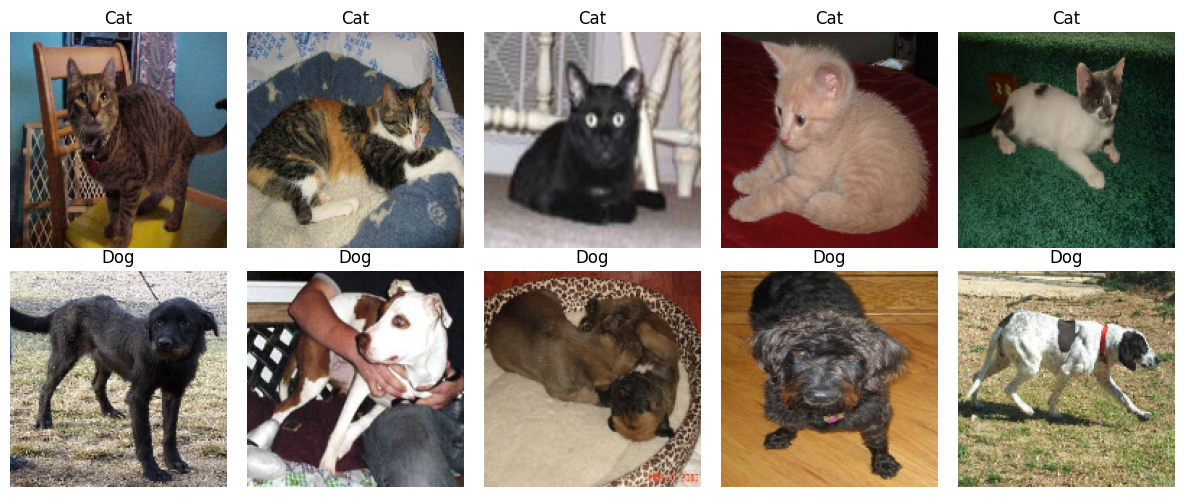

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    axes[0, i].imshow(cv2.cvtColor((cats_train[i] * 255).astype("uint8"), cv2.COLOR_BGR2RGB))
    axes[0, i].axis("off")
    axes[0, i].set_title("Cat")

for i in range(5):
    axes[1, i].imshow(cv2.cvtColor((dogs_train[i] * 255).astype("uint8"), cv2.COLOR_BGR2RGB))
    axes[1, i].axis("off")
    axes[1, i].set_title("Dog")

plt.tight_layout()
plt.show()

### Designing the CNN:

- 3 Convolutional Layers, kernel size 3x3, ReLU activation.
- All max pooling with 2x2 kernels.
- Flatten, then fully connected, sigmoid output.

In [4]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [5]:
from sklearn.utils import shuffle
import math

train_set, train_labels = shuffle(train_set, train_labels, random_state=42)

epochs = 100
display_step = epochs // 5

class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % display_step == 0:
            print(f"Epoch {epoch+1}/{epochs} - loss: {logs['loss']:.4f} - acc: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_acc: {logs['val_accuracy']:.4f}")

history = model.fit(
    train_set, train_labels,
    epochs=epochs,
    validation_data=(val_set, val_labels),
    batch_size=16,
    verbose=0,
    callbacks=[EpochLogger()]
)

Epoch 20/100 - loss: 0.0002 - acc: 1.0000 - val_loss: 2.8401 - val_acc: 0.6150
Epoch 40/100 - loss: 0.0000 - acc: 1.0000 - val_loss: 4.4809 - val_acc: 0.6300
Epoch 60/100 - loss: 0.0000 - acc: 1.0000 - val_loss: 6.4600 - val_acc: 0.6150
Epoch 80/100 - loss: 0.0000 - acc: 1.0000 - val_loss: 6.1729 - val_acc: 0.6000
Epoch 100/100 - loss: 0.0000 - acc: 1.0000 - val_loss: 7.6144 - val_acc: 0.5800


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

y_pred = (model.predict(val_set) > 0.5).astype("int32")

acc = accuracy_score(val_labels, y_pred)
prec = precision_score(val_labels, y_pred)
rec = recall_score(val_labels, y_pred)
cm = confusion_matrix(val_labels, y_pred)

print("Validation Accuracy:", acc)
print("Validation Precision:", prec)
print("Validation Recall:", rec)
print("Confusion Matrix:\n", cm)

7/7 [==============================] - 0s 3ms/step
Validation Accuracy: 0.58
Validation Precision: 0.5754716981132075
Validation Recall: 0.61
Confusion Matrix:
 [[55 45]
 [39 61]]


### HOG Feature Extraction with Logistic Regression

In [11]:
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression

def extract_hog_features(images):
    features = []
    for img in images:
        img_uint8 = (img * 255).astype("uint8")
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feat)
    return np.array(features)

X_train_hog = extract_hog_features(train_set)
X_val_hog = extract_hog_features(val_set)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_hog, train_labels)

y_pred_train = logreg.predict(X_train_hog)
y_pred_val = logreg.predict(X_val_hog)

acc_train = accuracy_score(train_labels, y_pred_train)
prec_train = precision_score(train_labels, y_pred_train)
rec_train = recall_score(train_labels, y_pred_train)

acc_val = accuracy_score(val_labels, y_pred_val)
prec_val = precision_score(val_labels, y_pred_val)
rec_val = recall_score(val_labels, y_pred_val)
cm_val = confusion_matrix(val_labels, y_pred_val)

print("Train Accuracy:", acc_train)
print("Train Precision:", prec_train)
print("Train Recall:", rec_train)
print("Validation Accuracy:", acc_val)
print("Validation Precision:", prec_val)
print("Validation Recall:", rec_val)
print("Validation Confusion Matrix:\n", cm_val)

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Validation Accuracy: 0.65
Validation Precision: 0.65
Validation Recall: 0.65
Validation Confusion Matrix:
 [[65 35]
 [35 65]]


### Comparison of CNN vs HOG + ML

Both approaches show clear sign of overfitting. A few possible culprits:

- Network not viable to learn this kind of data, resorting to memorizing the train set.
- Dogs vs Cats is non-trivial, other aspect affects prediction like background bias, color, etc...
- Possibly too little data to capture the complexity of the task.

Possible suggestions for improvement:

- Data augmentation, find more sample...
- More complex network.
- When dataset is in better condition, regularization becomes more crucial.